In [1]:
import glob
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time

import proplot as pplt
import seaborn as sns
import sklearn
import re 
from fractions import Fraction
import scipy.stats as st

label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})

device = 'cpu' # device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from utils import *
from plotting_functions import *

label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#load model
current_dir = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation"
exp_extension = "\\experiments\\poisson_clicks\\perfect_model\\"
exp_extension = "\\experiments\\poisson_clicks\\"

# Bigger test set + 1.001 ratio: 1674073326
# 2 layer: 6138
# Perf V2: 
    # -disc.: 8886
    # -cont.: 8697
#continual learning: 6541
# N100: 3892
# --low rate: 1673013320, 1673714210 (summed BPTT), 1673788646
# N30: 8288
#with diagonal constraint: 5398
# with spectrum constraint: 1667906971, 6168
# without: 6701
exp_list = glob.glob(current_dir + exp_extension + "\\exp*1674921256") #92
exp_path = exp_list[0]

In [7]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

training_kwargs['constrain_spectrum'] = False
training_kwargs['device'] = device
# device = training_kwargs['device']

makedirs(training_kwargs['figures_path'])
rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=training_kwargs['n_layers'], transform_function='relu', constrain_spectrum=training_kwargs['constrain_spectrum']).to(device)
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key].cpu()) for key in rnn_model.state_dict().keys()}
#recurrent weights
try:
    W_hh = weights_dict['rnn.weight_hh_l0']
except:
    W_hh = weights_dict['rnn.parametrizations.weight_hh_l0.original']
# W_hh.to_numpy()

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\exp_equalclicks_bcewll_adam_steplr_actnormlambda0.0001_rnn_cued_Nrec100_1674921256\weights1674921256.pth


In [8]:
N_test_batch = 10**3
training_kwargs['T'] = 20000
training_kwargs['hidden_initial_variance'] = 1
# equal_clicks  
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x, y, output_mask, trial_params = data_set = pd.get_trial_batch() #generate self.N_batch trials
x *= 0

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=10)
yhat = yhat.cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()

In [9]:
# Find fixed points from dynamics
fxd_pnts = np.unique(np.round(hidden_states[:,-1,:], 3), axis=0)
N_fxdpnts = fxd_pnts.shape[0]
N_fxdpnts

190

In [10]:
# Get transient dynamics from nbhd around fixed points -> paths between fixed points\

N_batch = 500
time_steps = int(training_kwargs['T']/training_kwargs['dt'])
zero_input = torch.zeros((N_batch, time_steps, 4))

trajectories = np.empty((N_fxdpnts, N_batch, time_steps, training_kwargs['N_rec'])) 
for i,fxdpnt in enumerate(fxd_pnts): 
    # hidden_init = np.tile(fxdpnt,(N_batch,1))
    # hidden_init += np.random.normal(0, .05, hidden_init.shape)
    # hidden_init = torch.tensor(hidden_init.reshape((training_kwargs['n_layers'], hidden_init.shape[0], hidden_init.shape[1])))
    
    hidden_init = torch.normal(mean=0, std=training_kwargs['hidden_initial_variance'], size=(training_kwargs['n_layers'], N_batch, training_kwargs['N_rec'])).to(training_kwargs['device'])
        
    yhat, hidden_states = run_model_chunked(zero_input, rnn_model, hidden_init=hidden_init, n_chunks=1)
    hidden_states = hidden_states.cpu().detach().numpy()
    trajectories[i] = hidden_states

MemoryError: Unable to allocate 142. GiB for an array with shape (190, 500, 2000, 100) and data type float64

In [ ]:
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)
times = np.linspace(0, training_kwargs['T'], trajectories[i][0, :, 0].shape[0])

hidden_i = 1
for i, fxdpnt in enumerate(fxd_pnts):
    for trial_i in range(trajectories.shape[1]):
        hs = ax.plot(times, trajectories[i][trial_i, :, hidden_i], color='r')
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')

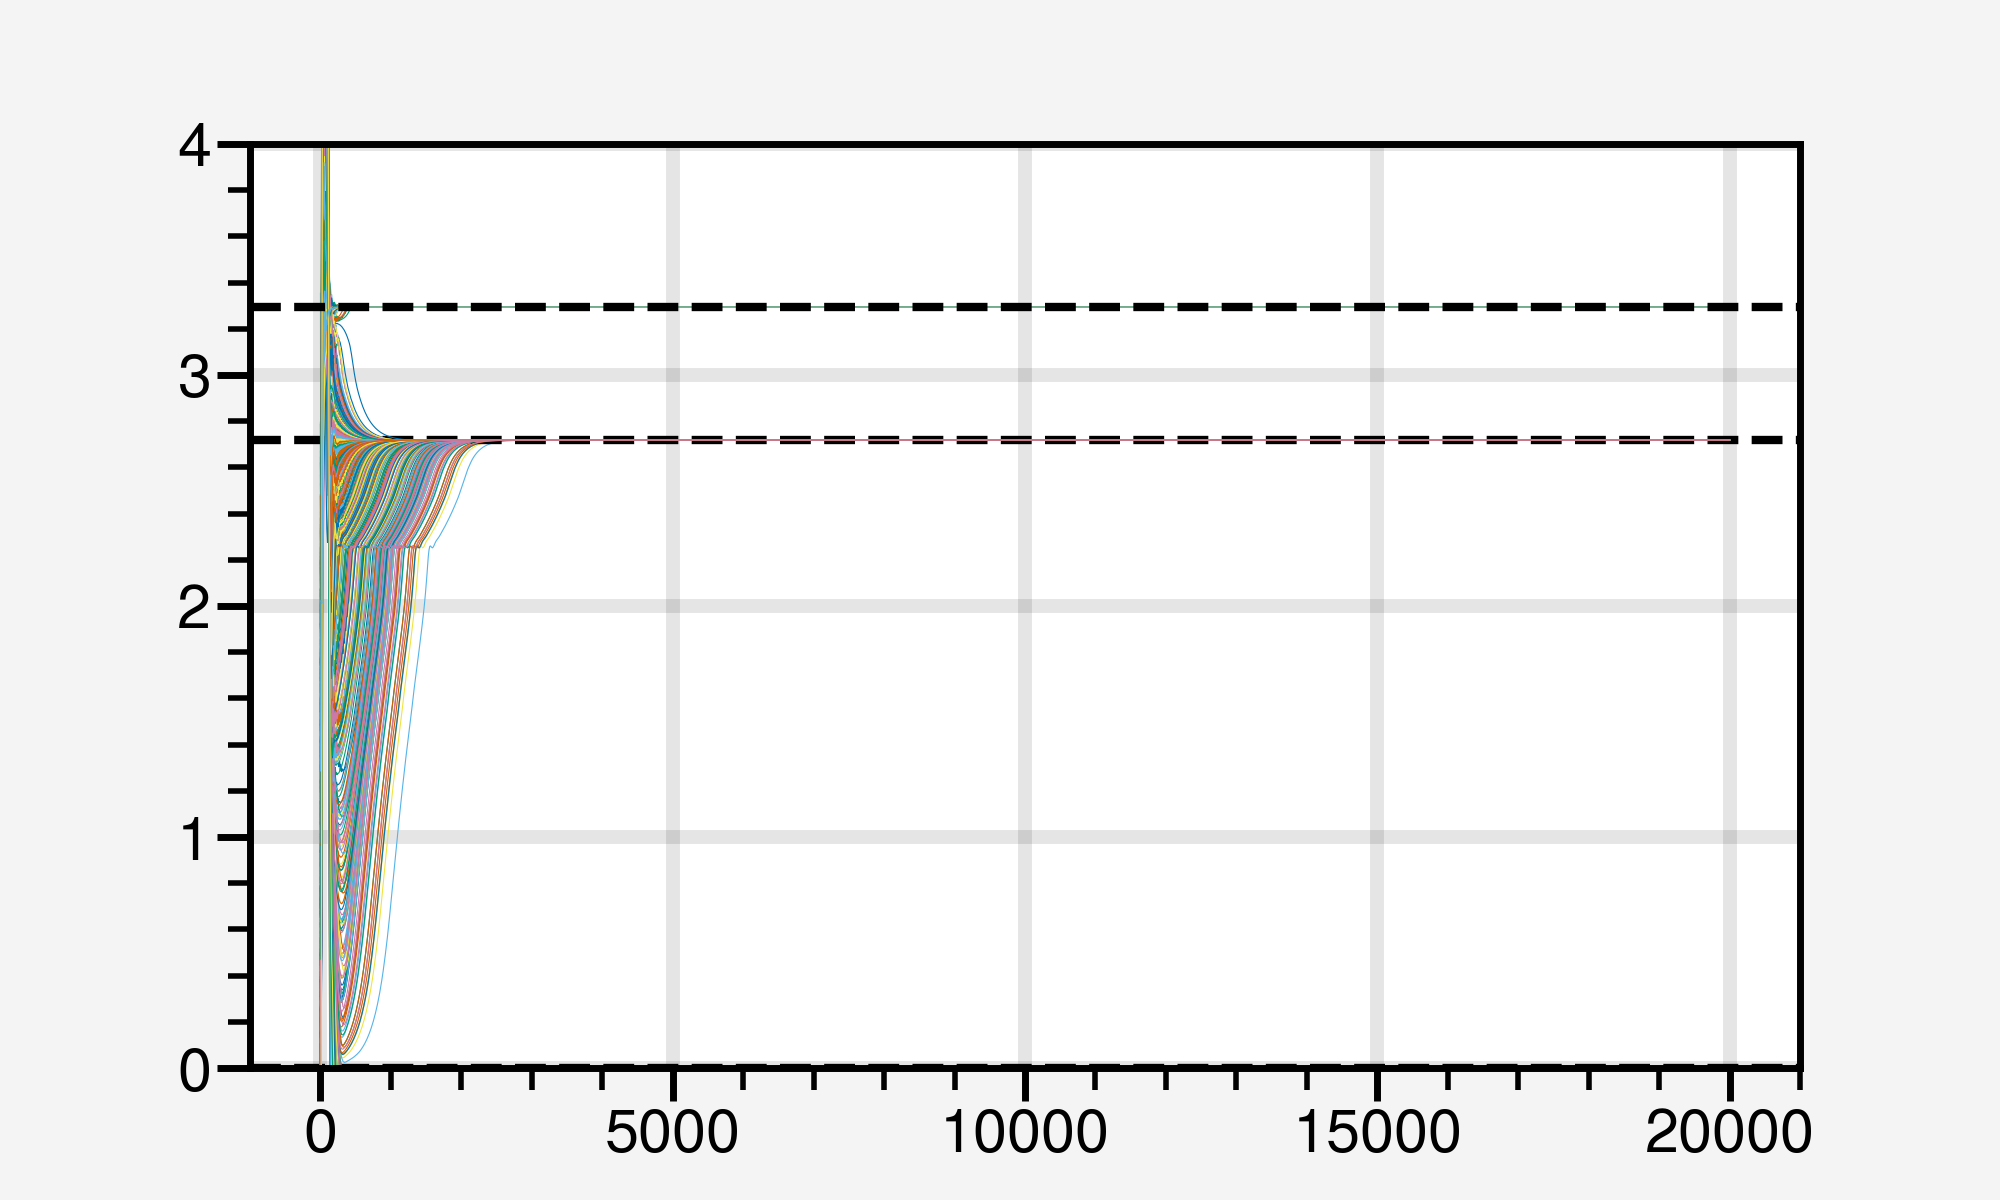

In [13]:
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)
times = np.linspace(0, training_kwargs['T'], trajectories[i][0, :, 0].shape[0])

for i, fxdpnt in enumerate(fxd_pnts):
    for trial_i in range(trajectories.shape[1]):
        hs = ax.plot(times, trajectories[i][trial_i, :, hidden_i], linewidth=0.4)
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')
    
ax.set_ylim([0,4]);

In [14]:
traj_flat = np.reshape(trajectories, (N_batch*N_fxdpnts, time_steps, training_kwargs['N_rec']))
np.where((traj_flat[:,hidden_i,:] != fxd_pnts[0]) & (traj_flat[:,hidden_i,:] != fxd_pnts[1]))[0].shape

# np.where((traj_flat[:,hidden_i,:] != fxd_pnts[0]) & (traj_flat[:,hidden_i,:] != fxd_pnts[1]) & (traj_flat[:,hidden_i,:] != fxd_pnts[2]))[0].shape

i=1
np.where(~np.isclose(trajectories[i][:,1000,hidden_i], fxd_pnts[i][hidden_i], rtol=1e-04))

transient_trials = np.where(~np.isclose(np.round(trajectories[i][:,-1,hidden_i], 3), fxd_pnts[i][hidden_i]))[0]
transient_trials

array([  1,   2,   6,   7,   8,  10,  11,  12,  15,  16,  17,  20,  21,
        23,  25,  26,  28,  30,  31,  32,  33,  35,  38,  42,  44,  47,
        51,  52,  54,  60,  63,  65,  68,  70,  71,  73,  77,  78,  82,
        83,  86,  89,  90,  93,  97,  99, 101, 102, 103, 105, 106, 111,
       112, 114, 116, 117, 122, 124, 127, 128, 129, 131, 133, 136, 138,
       141, 142, 144, 145, 148, 149, 150, 151, 152, 153, 155, 159, 163,
       165, 166, 170, 174, 175, 176, 177, 178, 182, 184, 185, 188, 189,
       191, 193, 195, 198, 199, 201, 202, 205, 206, 209, 212, 213, 219,
       220, 228, 229, 232, 241, 242, 243, 247, 250, 257, 258, 259, 261,
       264, 267, 268, 269, 270, 273, 274, 276, 277, 278, 281, 282, 285,
       286, 287, 288, 290, 294, 295, 296, 297, 298, 300, 303, 305, 308,
       310, 313, 315, 319, 323, 327, 330, 334, 335, 336, 337, 339, 344,
       345, 347, 348, 349, 350, 351, 353, 354, 356, 357, 359, 361, 364,
       366, 369, 371, 374, 375, 376, 384, 386, 388, 394, 397, 40

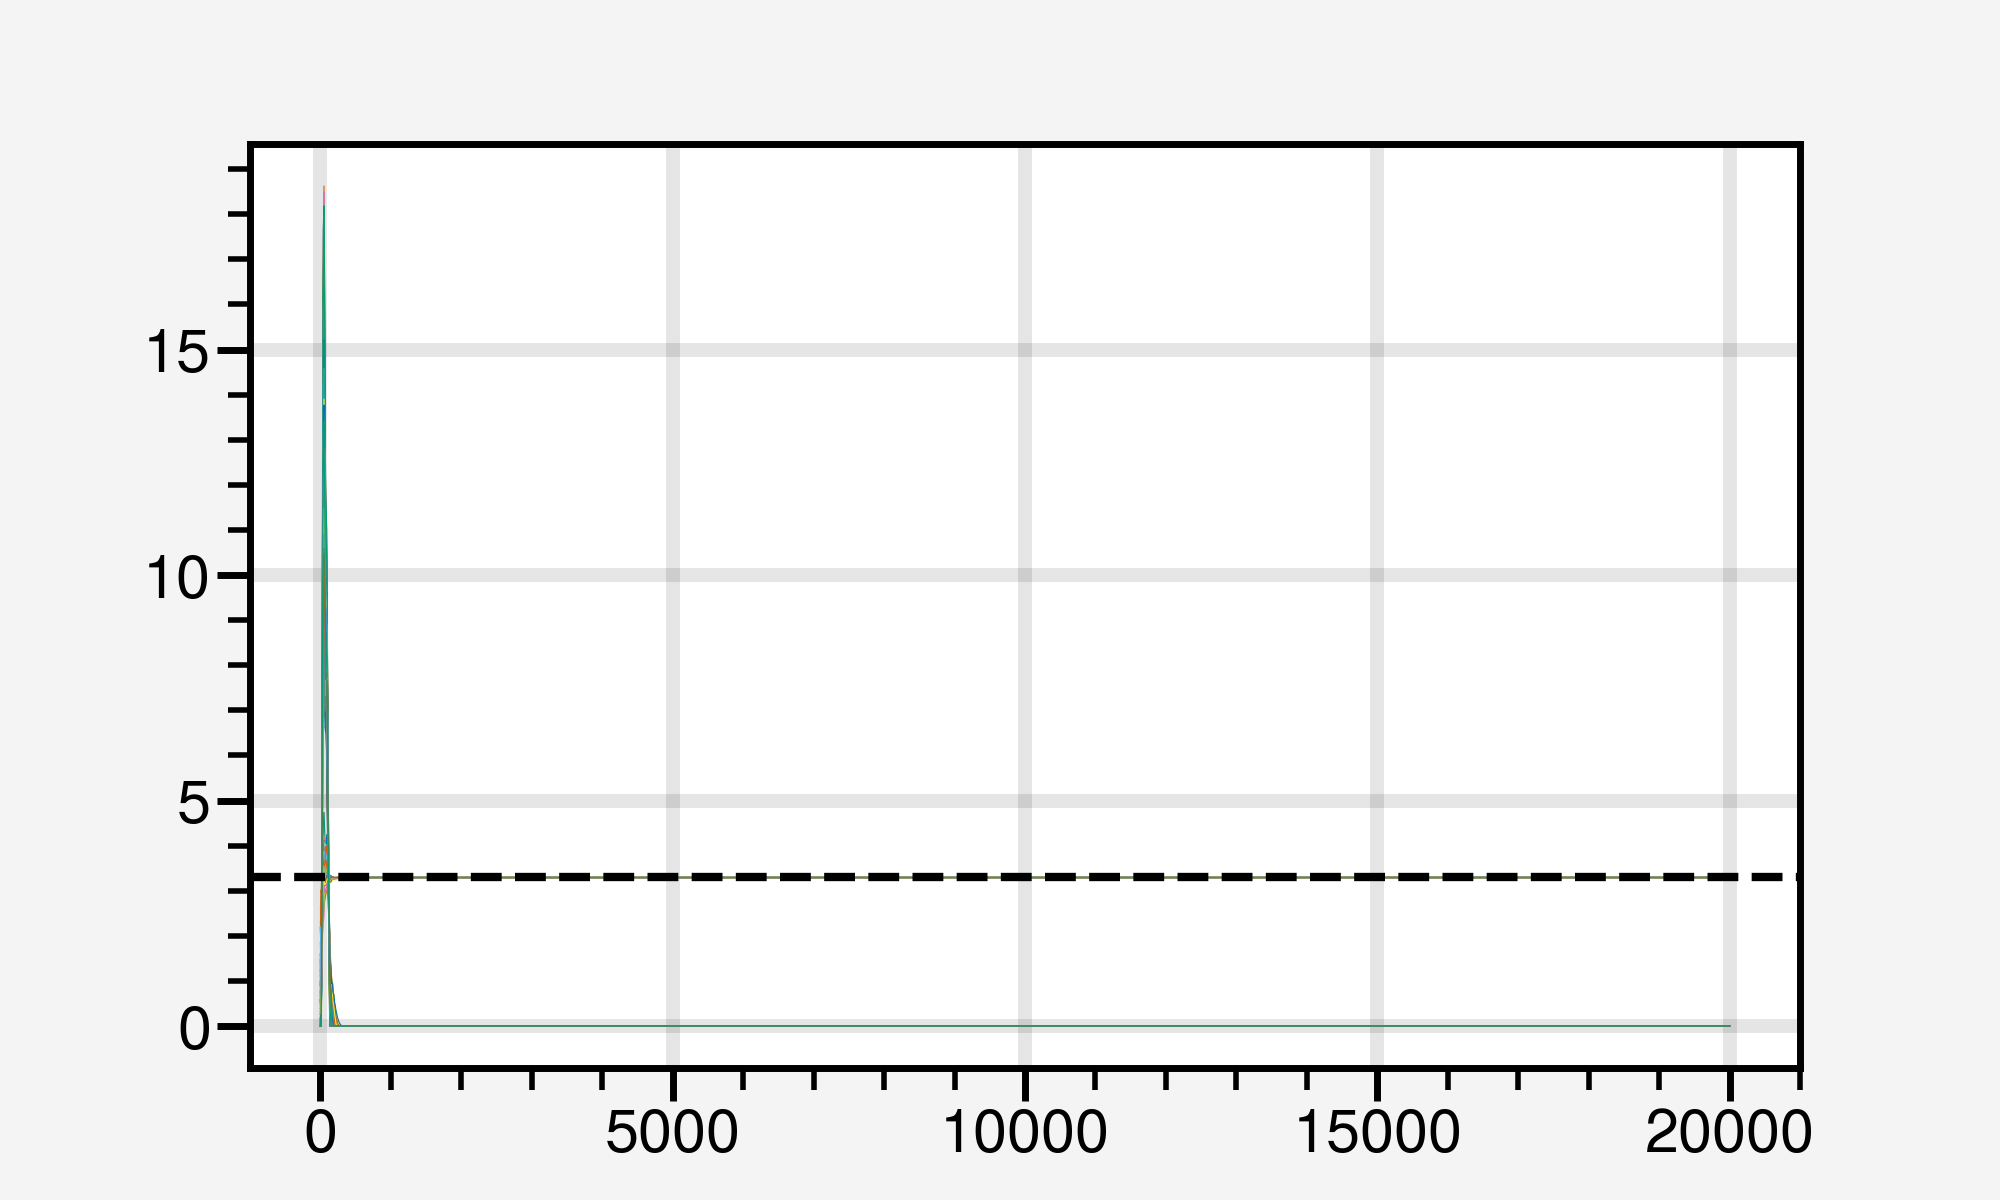

In [15]:
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for trial_i in transient_trials:
    hs = ax.plot(times, trajectories[i][trial_i, :, hidden_i], linewidth=0.4)
    
plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')

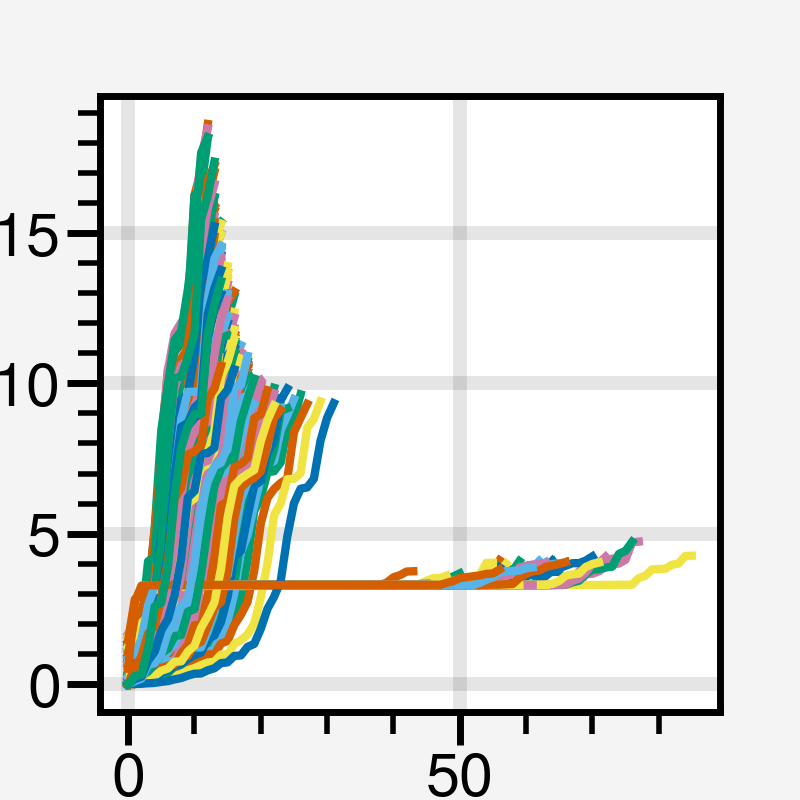

In [16]:
for trial_i in transient_trials:
    transient_traj = np.unique(trajectories[i][trial_i, :, hidden_i])
    plt.plot(transient_traj)

In [17]:
def create_inputs(time_steps, start, end, step=1):
    x = np.zeros((2, int((end-start)/step), time_steps, 4))
    for side in range(2):
        for t in range(start, end-1, step):
            x[side, int((t-start)/step), t, side] = 1.
    return x

def create_inputs_pulse(time_steps, start, end):
    x = np.zeros((2, end-start, time_steps, 4))
    for side in range(2):
        for t in range(start, end):

            x[side, t-start, start:t+1, side] = 1.
    return x

In [18]:
start = 500
end = 503
step = 1
# xlr = create_inputs(time_steps, start, end, step=step)
xlr = create_inputs_pulse(time_steps, start, end)
i=1
trial_i = transient_trials[1]

#CLICKS ON lEFT
x = torch.tensor(xlr[0], dtype=torch.float)
hidden_init = np.tile(trajectories[i][trial_i, 0, :],(int((end-start)/step),1)).reshape((1, x.shape[0], training_kwargs['N_rec']))
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_init=torch.tensor(hidden_init, dtype=torch.float), n_chunks=1)
hidden_states = hidden_states.cpu().detach().numpy()

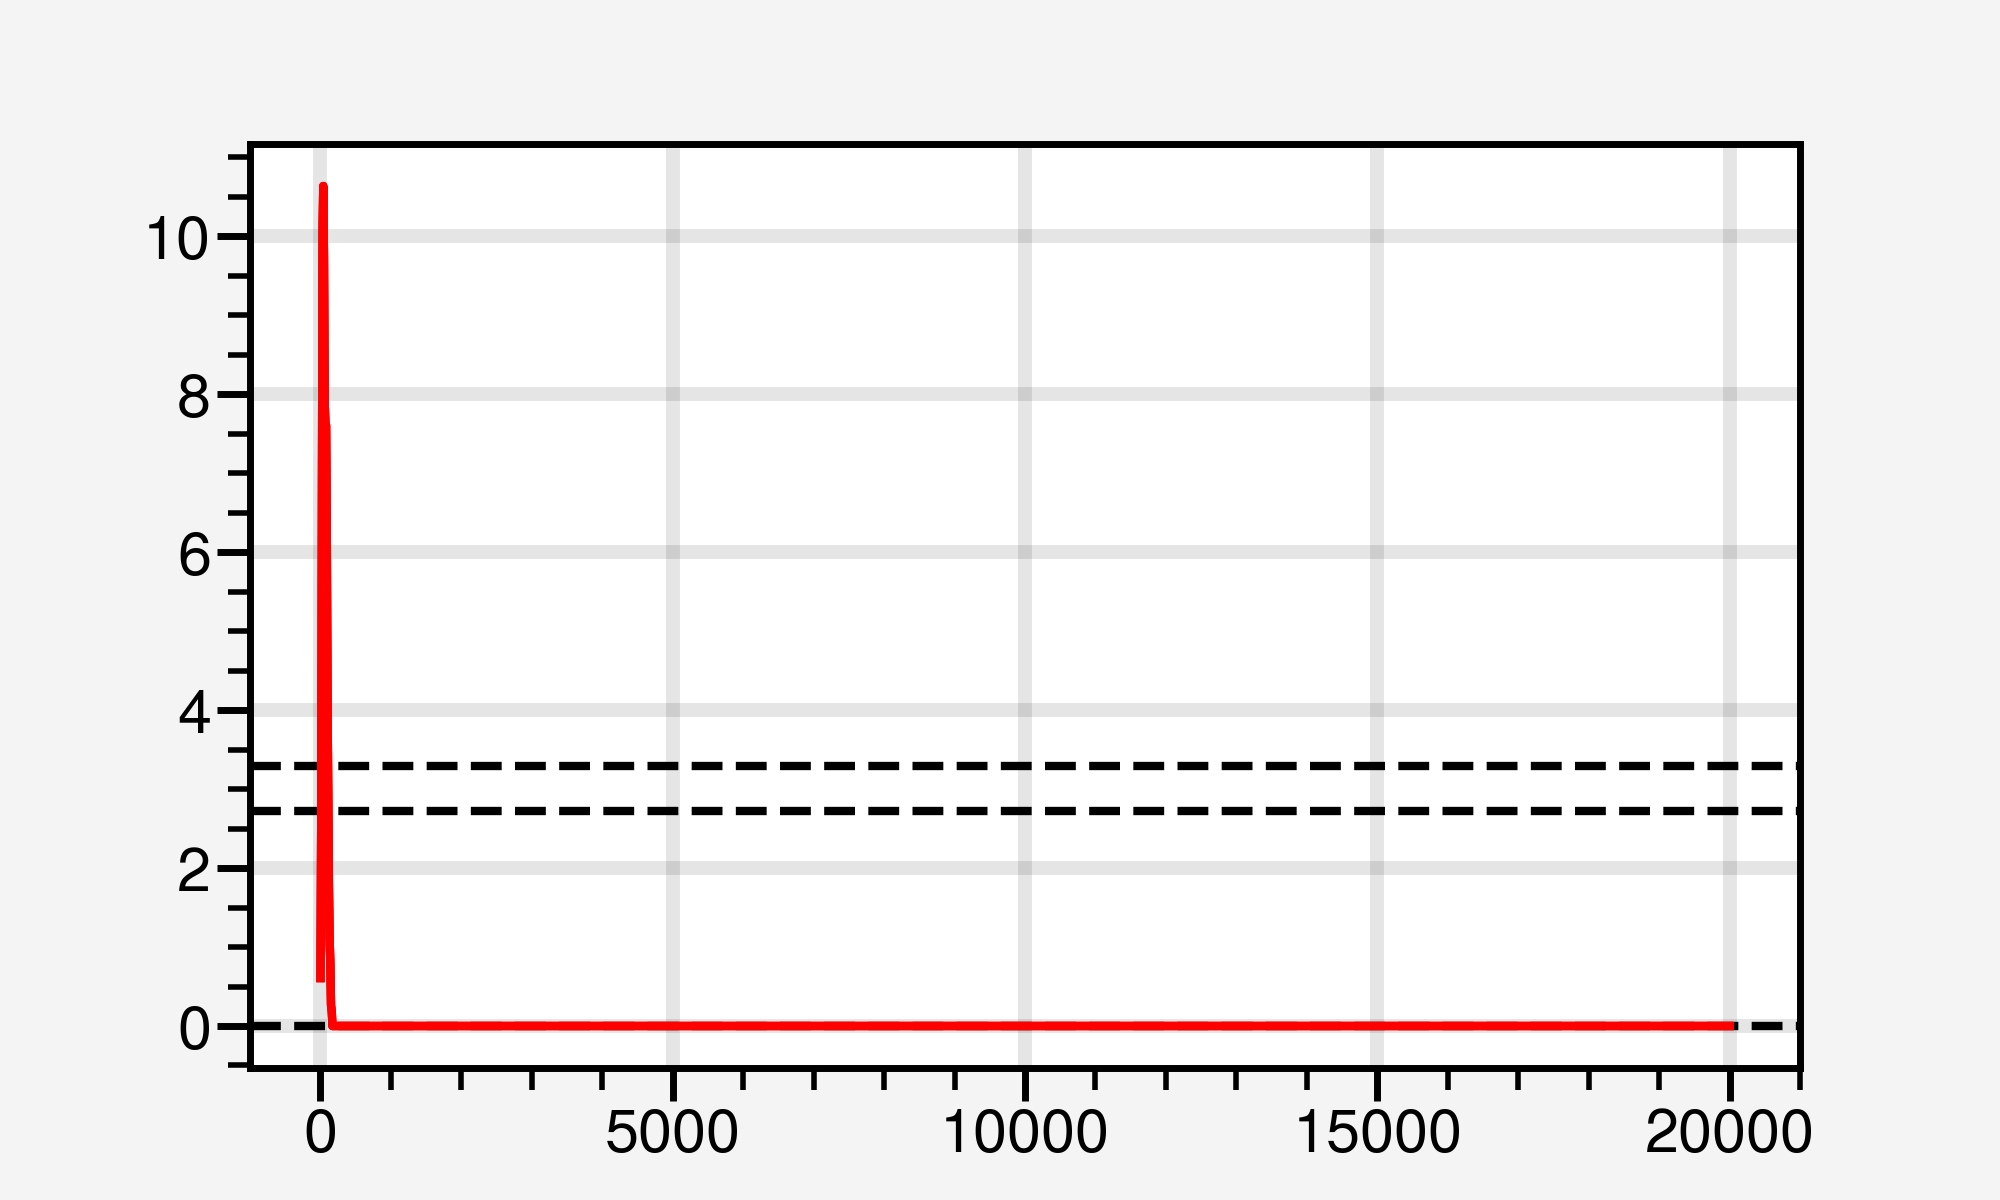

In [19]:
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for i, fxdpnt in enumerate(fxd_pnts):
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')
    
for trial_i in range(hidden_states.shape[0]):
    hs = ax.plot(times, hidden_states[trial_i, :, hidden_i], color='r')

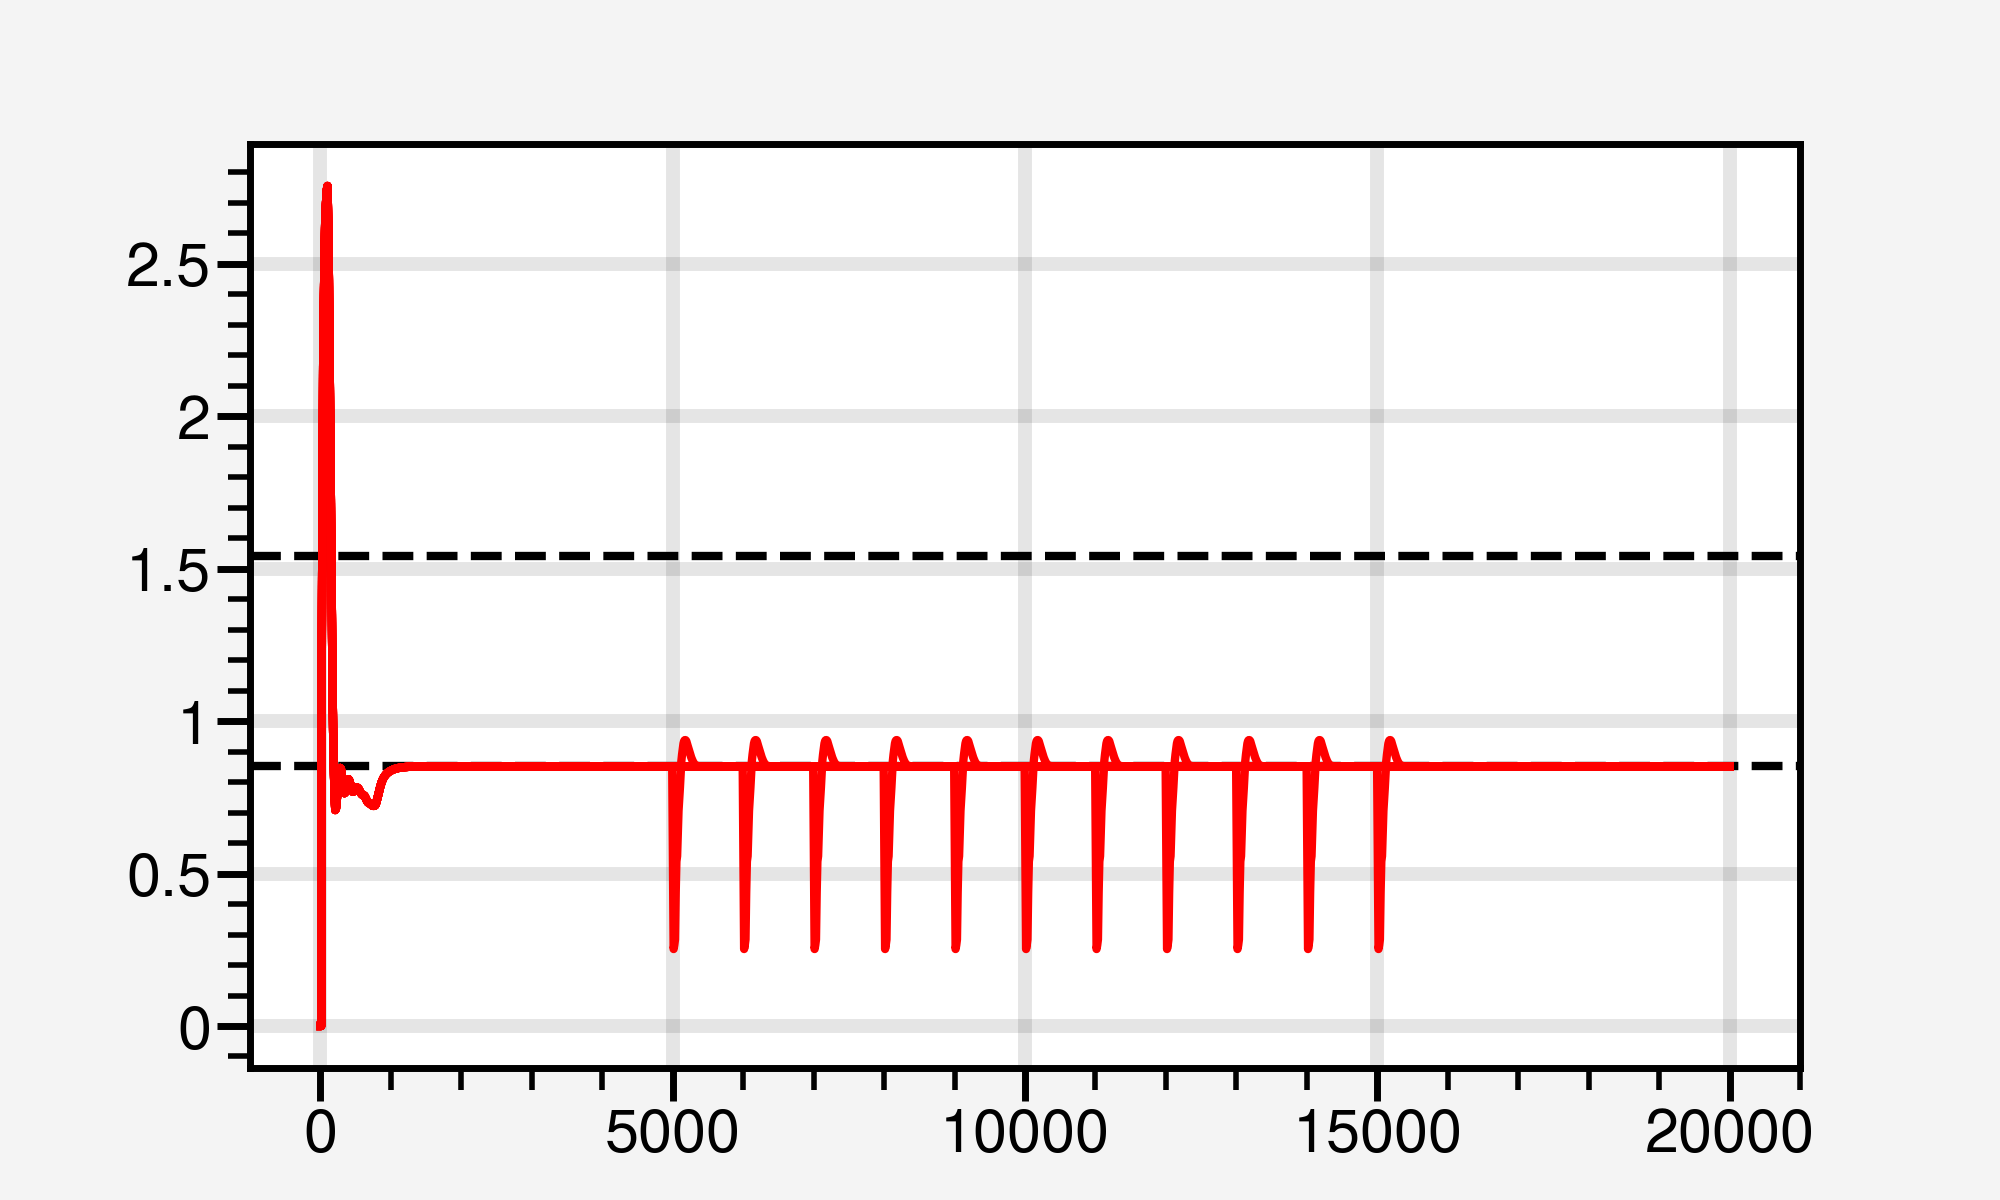

In [76]:
#CLICKS ON RIGHT

x = torch.tensor(xlr[1], dtype=torch.float)
yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_init=torch.tensor(hidden_init, dtype=torch.float), n_chunks=1)
hidden_states = hidden_states.cpu().detach().numpy()

fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for i, fxdpnt in enumerate(fxd_pnts):
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')
    
for trial_i in range(hidden_states.shape[0]):
    hs = ax.plot(times, hidden_states[trial_i, :, hidden_i], color='r')

number of clicks needed to get to the
- basin of the other decision
- on the other side of the decision boundary
    - while staying on this side after (infinite/ some finite time) 

C:\Users\abel_\AppData\Local\Temp\ipykernel_8376\553658263.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(hs, ax=ax, label='Consecutive Clicks');


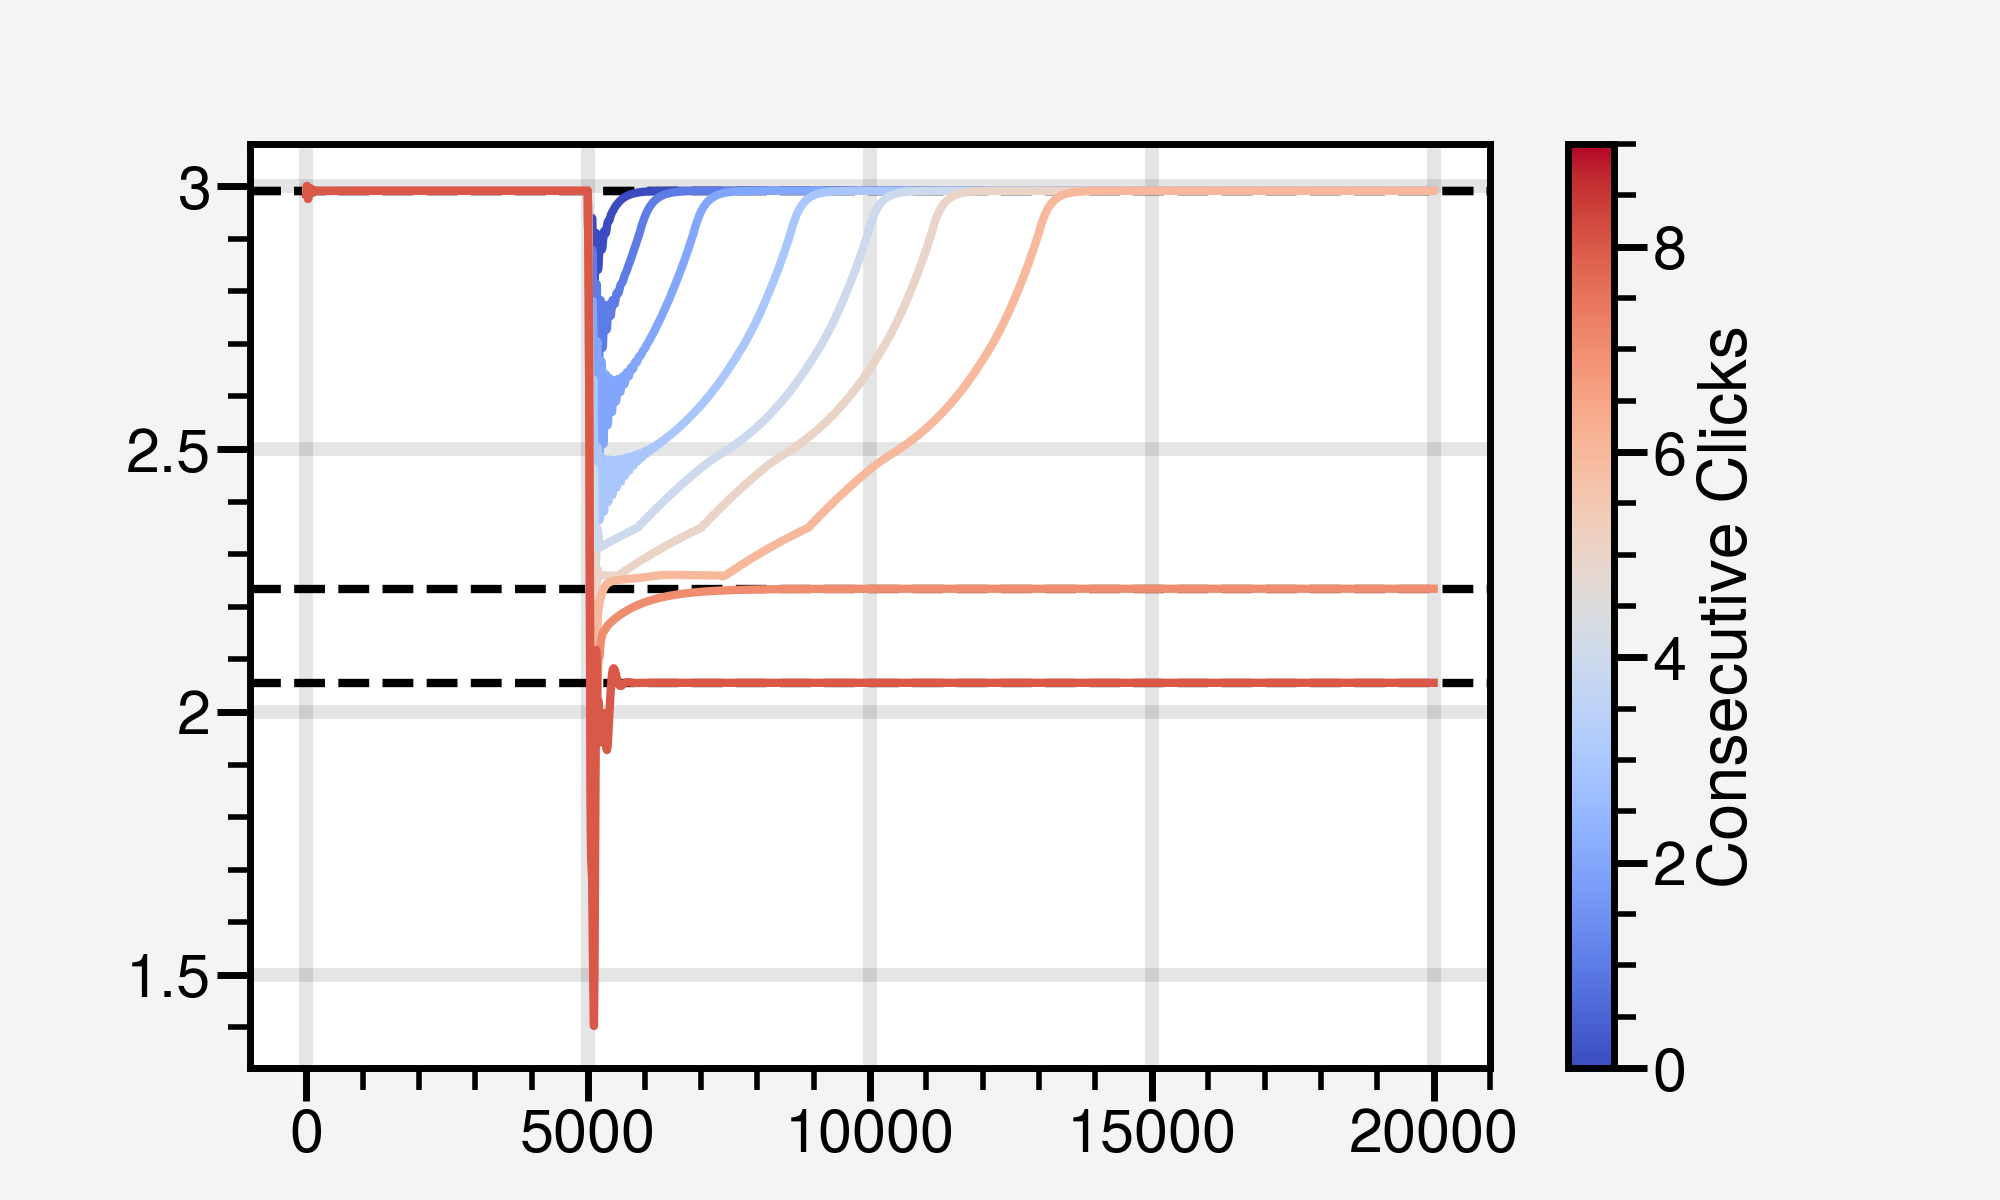

In [69]:
start = 500
end = 510
i=2
trial_i = transient_trials[1]
xlr = create_inputs_pulse(time_steps, start, end)

x = torch.tensor(xlr[1], dtype=torch.float)
hidden_init = np.tile(trajectories[i][trial_i, 0, :],(end-start-1,1)).reshape((1, x.shape[0], training_kwargs['N_rec']))

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_init=torch.tensor(hidden_init, dtype=torch.float), n_chunks=1)
hidden_states = hidden_states.cpu().detach().numpy()



norm = mplcolors.Normalize(vmin=0,vmax=end-start-1)
dnorm = norm(np.arange(end-start-1))
cmap = cmx.get_cmap("coolwarm")
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for i, fxdpnt in enumerate(fxd_pnts):
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')
    
for trial_i in range(hidden_states.shape[0]):
    hs = ax.plot(times, hidden_states[trial_i, :, hidden_i],  c=cmap(dnorm[trial_i]))
    
hs = ax.scatter(2, 2, c=0, s=0., cmap=cmap, vmin=0, vmax=end-start-1)
plt.colorbar(hs, ax=ax, label='Consecutive clicks');

C:\Users\abel_\AppData\Local\Temp\ipykernel_8376\1960783106.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(hs, ax=ax, label='Consecutive clicks');


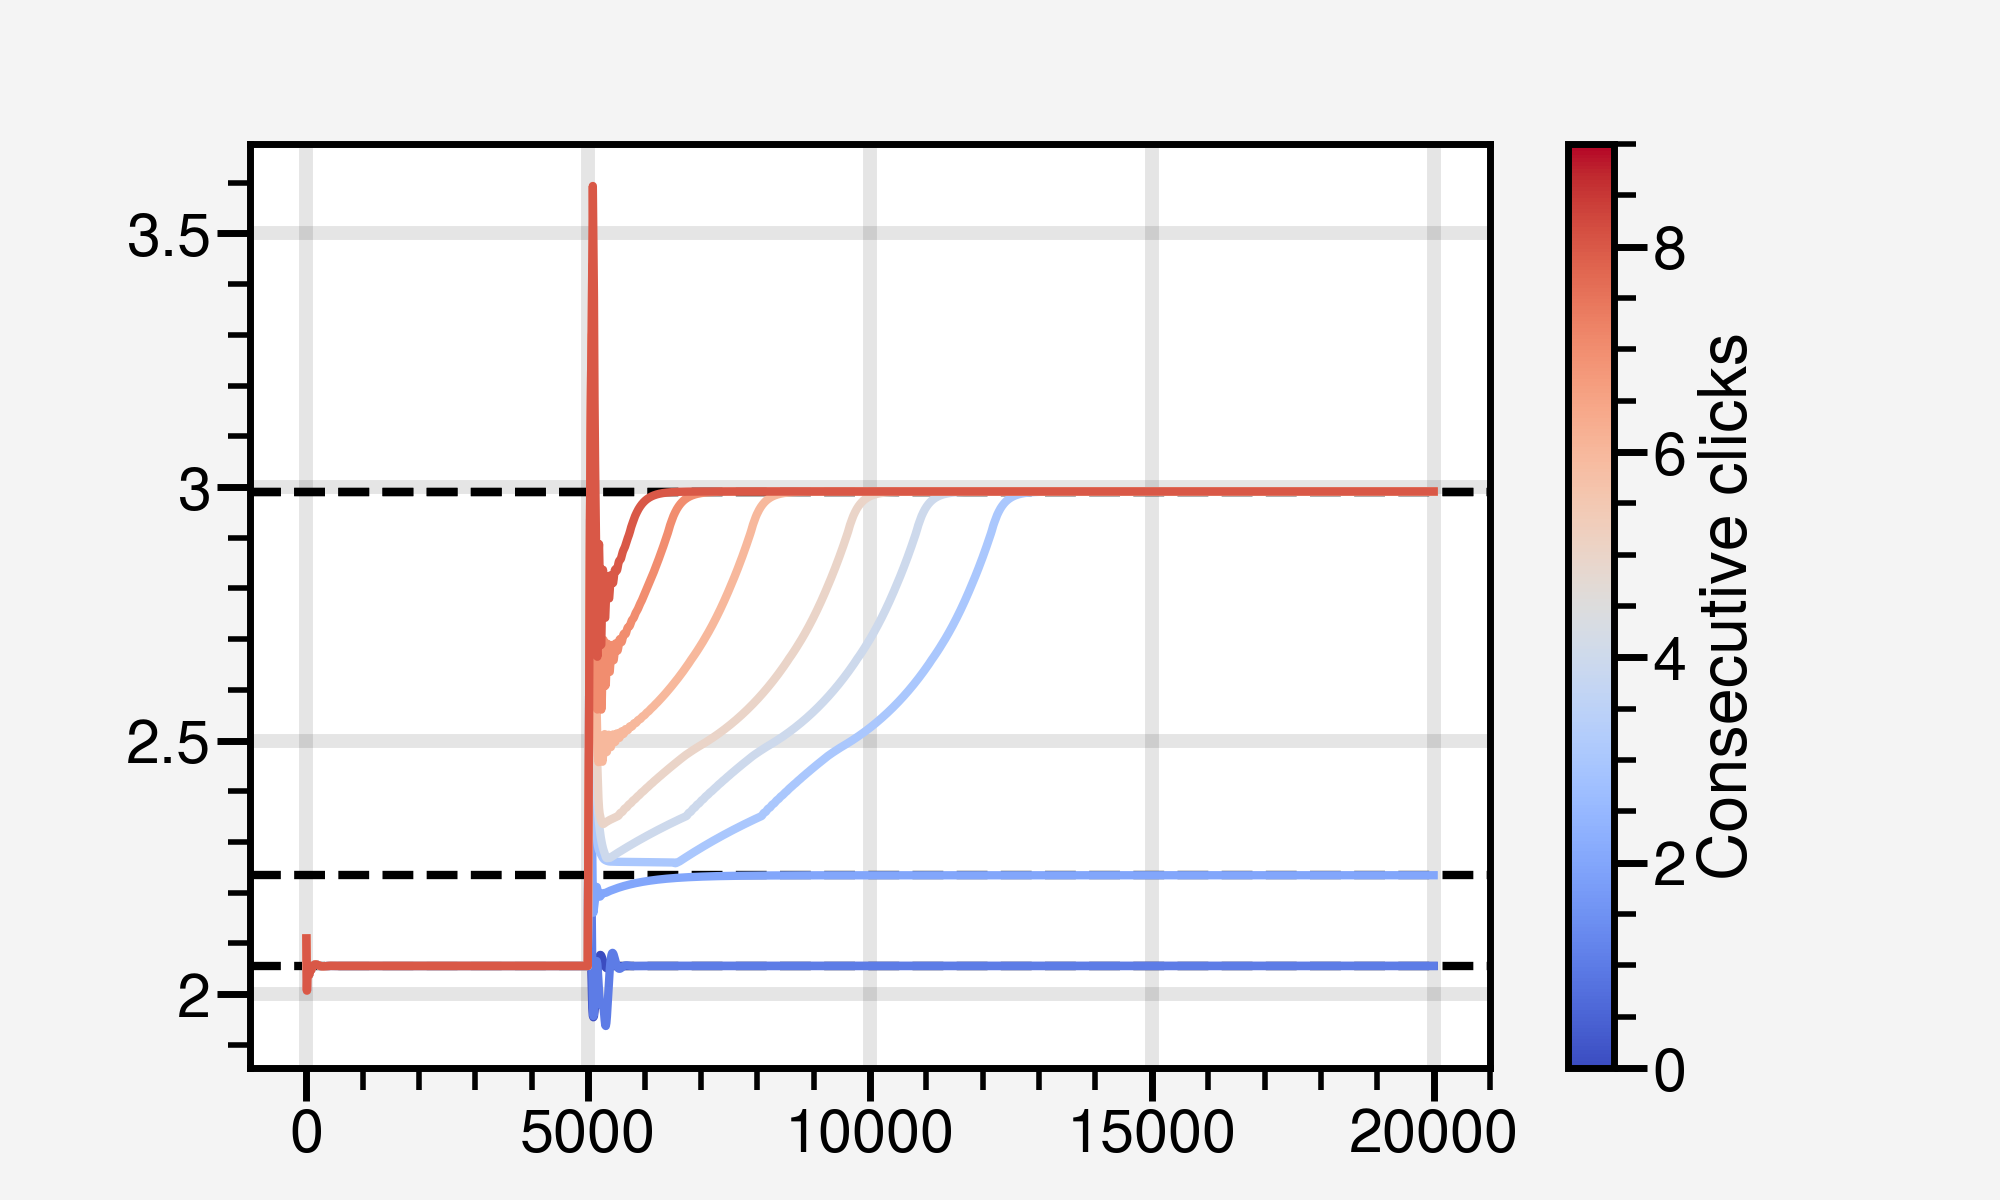

In [73]:
i=0
trial_i = transient_trials[0]
xlr = create_inputs_pulse(time_steps, start, end)

x = torch.tensor(xlr[0], dtype=torch.float)
hidden_init = np.tile(trajectories[i][trial_i, 0, :],(end-start-1,1)).reshape((1, x.shape[0], training_kwargs['N_rec']))

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_init=torch.tensor(hidden_init, dtype=torch.float), n_chunks=1)
hidden_states = hidden_states.cpu().detach().numpy()


norm = mplcolors.Normalize(vmin=0,vmax=end-start-1)
dnorm = norm(np.arange(end-start-1))
cmap = cmx.get_cmap("coolwarm")
fig=plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for i, fxdpnt in enumerate(fxd_pnts):
    plt.axhline(y=fxdpnt[hidden_i], color='k', linestyle='--')
    
for trial_i in range(hidden_states.shape[0]):
    hs = ax.plot(times, hidden_states[trial_i, :, hidden_i],  c=cmap(dnorm[trial_i]))
    
hs = ax.scatter(2, 2, c=0, s=0., cmap=cmap, vmin=0, vmax=end-start-1)
plt.colorbar(hs, ax=ax, label='Consecutive clicks');